In [2]:
# define the LDenseNet
import tensorflow as tf

def Conv_1D_Block(x, model_width, kernel, strides):
    x = tf.keras.layers.Conv1D(model_width, kernel, strides=strides, padding="same")(x)
    x = tf.keras.layers.Activation('swish')(x)
    return x

def stem(inputs, num_filters, filter_len):

    conv = Conv_1D_Block(inputs, num_filters, filter_len, 2)
    if conv.shape[1] <= 2:
        pool = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="same")(conv)
    else:
        pool = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding="same")(conv)

    return pool

def conv_block(x, num_filters, kernel_lens, bottleneck=True):
    if bottleneck:
        num_filters_bottleneck = num_filters * 4
        x = Conv_1D_Block(x, num_filters_bottleneck, 1, 1)

    out = Conv_1D_Block(x, num_filters, kernel_lens, 1)
    return out

def dense_block(x, num_filters, num_layers, bottleneck=True):

    for i in range(num_layers):
        cb = conv_block(x, num_filters, 7, bottleneck=bottleneck)
        x = tf.keras.layers.concatenate([x, cb], axis=-1)
    return x

def build_model(input_shape, output_dims):
    inputs = tf.keras.Input(input_shape)
    stem_block = stem(inputs, num_filters=16, filter_len=11)
    Dense_Block_1 = dense_block(stem_block, num_filters = 8, num_layers = 3, bottleneck=True)
    x = tf.keras.layers.GlobalAveragePooling1D()(Dense_Block_1)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(output_dims, activation='softmax')(x)
    model = tf.keras.Model(inputs, x)
    return model

In [3]:
input_shape = (1200,3)
output_dims = 4
model = build_model(input_shape, output_dims)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1200, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 600, 16)      544         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 600, 16)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 300, 16)      0           activation[0][0]                 
______________________________________________________________________________________________

In [5]:
# load model weights
model.load_weights('./saved_model/LDenseNet/')

In [7]:
#load ecg data
import numpy as np
import matplotlib.pyplot as plt
normal_sample = np.load('./example/samples.npy')
print(normal_sample.shape)

(10, 5000, 12)


In [44]:
#choose III, avR, and V6 as model input
model_input = normal_sample[:,:,[2,3,-1]]
print(model_input.shape)

(10, 5000, 3)


In [31]:
def plot_ecgs(x):
    for i in range(x.shape[-1]):
        plt.subplot(x.shape[-1], 1, i+1)
        plt.plot(x[:, i])
    plt.show()

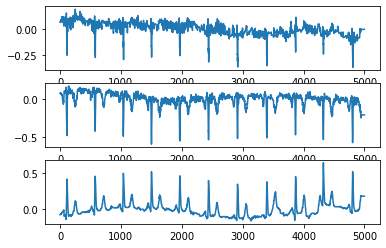

In [32]:
plot_ecgs(model_input[0])

In [41]:
#preprocess the ecgs
import neurokit2 as nk
import scipy.signal
def preprocess_data(raw_data):
    def leads_preprocess(leads):
        pre_leads = []
        for i in range(leads.shape[0]):
            lead = leads[i]
            lead = nk.signal_filter(lead, sampling_rate=500, lowcut=0.5, highcut=35, order=5) # denoise by butterworth bandpass filter
            lead = scipy.signal.resample(lead, int(lead.shape[0]/500*120)) #downsample to 120Hz
            lead = (lead - np.mean(lead)) / np.std(lead) if np.std(lead)!=0 else np.zeros_like(lead) # Z-score normalization
            pre_leads.append(lead)
        pre_leads = np.array(pre_leads)
        return pre_leads
    
    raw_data = np.transpose(raw_data, [0,2,1])
    preprocessed_data = []
    for i in range(raw_data.shape[0]):
        ecgs = leads_preprocess(raw_data[i])
        preprocessed_data.append(ecgs)
    preprocessed_data = np.array(preprocessed_data, dtype = 'float32')
    preprocessed_data = np.transpose(preprocessed_data, [0,2,1])
    return preprocessed_data

(10, 1200, 3)


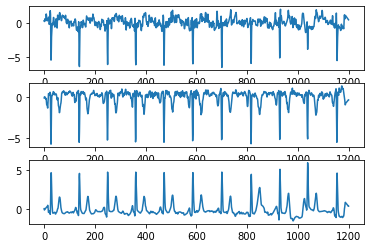

In [45]:
model_input = preprocess_data(model_input)
print(model_input.shape)
plot_ecgs(model_input[0])

In [46]:
#limb lead misplacement detection
# 0: Normal, 1:LA/RA, 2:RA/LL, 3:LA//LL
result = model.predict(model_input)
result = np.argmax(result, axis=-1)
print(result) # all normal

[0 0 0 0 0 0 0 0 0 0]


(10, 12, 5000)
(10, 1200, 3)


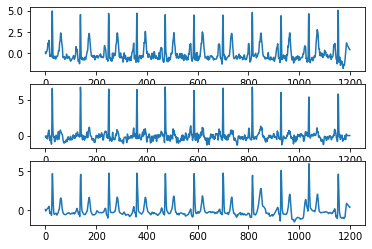

In [65]:
#simulate limb lead misplacement
def interchange_transform(mode,normal_leads):
    transformed_leads = np.copy(normal_leads)
    if mode == 1:#LA/RA
        transformed_leads[0]=-normal_leads[0]
        transformed_leads[1]=normal_leads[2]
        transformed_leads[2]=normal_leads[1]
        transformed_leads[3]=normal_leads[4]
        transformed_leads[4]=normal_leads[3]
    elif mode == 2:#RA/LL
        transformed_leads[0]=-normal_leads[2]
        transformed_leads[1]=-normal_leads[1]
        transformed_leads[2]=-normal_leads[0]
        transformed_leads[3]=normal_leads[5]
        transformed_leads[5]=normal_leads[3]
    elif mode == 3:#LA//LL
        transformed_leads[0]=normal_leads[1]
        transformed_leads[1]=normal_leads[0]
        transformed_leads[2]=-normal_leads[2]
        transformed_leads[4]=normal_leads[5]
        transformed_leads[5]=normal_leads[4]
    else:
        pass
    return transformed_leads


limb_leads_misplacement_samples = np.copy(normal_sample)
limb_leads_misplacement_samples = np.transpose(limb_leads_misplacement_samples, [0,2,1])
print(limb_leads_misplacement_samples.shape)
mode = [1,2,3,0,1,2,3,0,1,2]
for i in range(normal_sample.shape[0]):
    limb_leads_misplacement_samples[i] = interchange_transform(mode[i],limb_leads_misplacement_samples[i])
limb_leads_misplacement_samples = np.transpose(limb_leads_misplacement_samples, [0,2,1])      
model_input = limb_leads_misplacement_samples[:,:,[2,3,-1]]
model_input = preprocess_data(model_input)
print(model_input.shape)
plot_ecgs(model_input[0])

In [66]:
# 0: Normal, 1:LA/RA, 2:RA/LL, 3:LA//LL
result = model.predict(model_input)
result = np.argmax(result, axis=-1)
print(result)

[1 2 3 0 1 2 3 0 1 2]
